Original img_ch2: min=0.0, max=9119.0
Original img_ch3: min=0.0, max=11191.0
Stacked two_channel_image: min=0.0, max=11191.0
After GetThirdChannel: ch1 min=-0.0570068359375, max=0.2340087890625
Before MinMaxChop: min=-0.0570068359375, max=0.2340087890625
After MinMaxChop: min=0.0, max=0.2340087890625
Final processed_image: min=0.0, max=0.2340087890625
Normalized processed_image: min=0.0, max=1.0


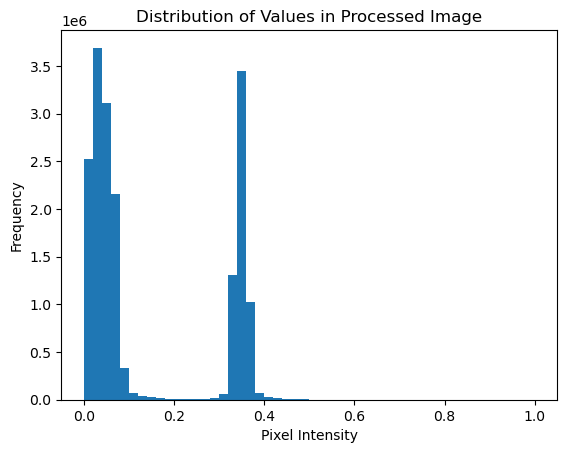

In [22]:
import pydicom
import matplotlib.pyplot as plt
from torchvision.transforms import Normalize
import torch
import numpy as np

class MinMaxChop(torch.nn.Module):
    """Clamps the images to float (0,1) range."""
    def __init__(self, min_val: float = 0.0, max_val: float = 1.0):
        super().__init__()
        self.min_ = min_val
        self.max_ = max_val

    def __call__(self, image: torch.Tensor) -> torch.Tensor:
        print(f"Before MinMaxChop: min={image.min()}, max={image.max()}")
        image = image.clamp(self.min_, self.max_)
        print(f"After MinMaxChop: min={image.min()}, max={image.max()}")
        return image

class GetThirdChannel(torch.nn.Module):
    """Computes the third channel of SRH image"""
    def __init__(self, subtracted_base: float = 5000 / 65536.0):
        super().__init__()
        self.subtracted_base = subtracted_base

    def __call__(self, two_channel_image: torch.Tensor) -> torch.Tensor:
        ch2 = two_channel_image[0, :, :]
        ch3 = two_channel_image[1, :, :]
        ch1 = ch3 - ch2 + self.subtracted_base
        print(f"After GetThirdChannel: ch1 min={ch1.min()}, max={ch1.max()}")
        return torch.stack((ch1, ch2, ch3), dim=0)

def get_srh_base_aug():
    """Base processing augmentations for all SRH images"""
    u16_min = (0, 0)
    u16_max = (65536, 65536)  # 2^16
    return [Normalize(u16_min, u16_max), GetThirdChannel(), MinMaxChop()]

# Load the DICOM files
dicom_file_1 = r"F:\Code\datasets\hidisc_data_small\studies\NIO_001\2\strips\CH2\img_2_7.dcm"
dicom_file_2 = r"F:\Code\datasets\hidisc_data_small\studies\NIO_001\2\strips\CH3\img_2_8.dcm"
ds_channel_1 = pydicom.dcmread(dicom_file_1)
ds_channel_2 = pydicom.dcmread(dicom_file_2)

# Extract pixel arrays and convert to tensors
img_ch2 = torch.tensor(ds_channel_1.pixel_array.astype(np.float32))
img_ch3 = torch.tensor(ds_channel_2.pixel_array.astype(np.float32))
print(f"Original img_ch2: min={img_ch2.min()}, max={img_ch2.max()}")
print(f"Original img_ch3: min={img_ch3.min()}, max={img_ch3.max()}")

# Stack the two channels
two_channel_image = torch.stack((img_ch2, img_ch3), dim=0)
print(f"Stacked two_channel_image: min={two_channel_image.min()}, max={two_channel_image.max()}")

# Apply the transformations
transforms = get_srh_base_aug()
transform_pipeline = torch.nn.Sequential(*transforms)
processed_image = transform_pipeline(two_channel_image)
print(f"Final processed_image: min={processed_image.min()}, max={processed_image.max()}")

# Normalize final processed image between 0 and 1
processed_image = (processed_image - processed_image.min()) / (processed_image.max() - processed_image.min())
print(f"Normalized processed_image: min={processed_image.min()}, max={processed_image.max()}")

# Check distribution of values in final processed image
plt.hist(processed_image.flatten().numpy(), bins=50)
plt.title("Distribution of Values in Processed Image")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

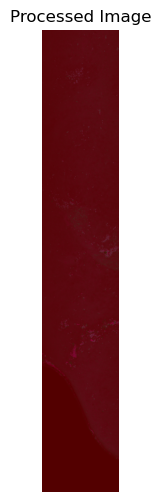

In [23]:
# Convert processed tensor back to numpy for visualization
processed_image_np = processed_image.numpy().transpose(1, 2, 0)  # Convert to (H, W, C) for visualization

# Display the processed image
plt.figure(figsize=(6, 6))
plt.imshow(processed_image_np, cmap='gray')
plt.title("Processed Image")
plt.axis("off")
plt.show()

# Extract the image data and apply the normalization above


(6000, 1000)

In [16]:
# # Define patch size
# patch_size = 1000
#
# # Compute number of patches
# num_patches = image.shape[0] // patch_size  # Should be 6 in this case
#
# # Create a figure to visualize patches
# fig, axes = plt.subplots(num_patches, num_patches, figsize=(12, 12))
#
# # Iterate through patches and plot them
# for i in range(num_patches):
#     for j in range(num_patches):
#         patch = image[i * patch_size : (i + 1) * patch_size,
#                       j * patch_size : (j + 1) * patch_size, :]
#         axes[i, j].imshow(patch)
#         axes[i, j].axis("off")  # Hide axes
#
# plt.tight_layout()
# plt.show()

# Define patch size
patch_height = 1000
num_patches = processed_image.shape[0] // patch_height  # Should be 6 patches

# Create a figure to visualize patches
fig, axes = plt.subplots(1, num_patches, figsize=(15, 5))

# Iterate through patches and plot them
for i in range(num_patches):
    patch = processed_image[i * patch_height : (i + 1) * patch_height, :]
    axes[i].imshow(patch, cmap="gray")  # Assuming grayscale
    axes[i].axis("off")  # Hide axes

plt.tight_layout()
plt.show()

ValueError: Number of columns must be a positive integer, not 0

<Figure size 1500x500 with 0 Axes>